In [1]:
# -*- coding: utf-8 -*-
"""
Titulo: Automatizacion reportes regionales
Created on Thu Aug 22 11:58:39 2019

Proceso que automatiza reportes regionales, generando un documento word por cada region.

Obs: Se deben revisar los inputs antes de correr

@author: hugo.gallardo
"""

# =============================================================================
# Extracción en python de datos de comunicado de compras a nivel regional
# =============================================================================

#Seteo de librerias

import pandas as pd
import numpy as np
import sqlalchemy as sa              #Para conexión a BD, requerido para usar pd.read_sql()
import urllib                        #Para formatear string de conexión

import docx
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import openpyxl as opxl             # OJO EN LA CASA para importar excel como dataframe

from docx import Document
from docx import shared
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.enum.text import WD_LINE_SPACING
from docxtpl import DocxTemplate, InlineImage   #rellenar templates

import seaborn as sns
import os
import sys
from pylab import savefig
import itertools

import pyodbc                               ### another engine to make DB connection and run the queries. Alternative to sqlalchemy
from itertools import repeat
import querysGR as qg

In [2]:
#Transforma codigo a word
#Agregar github


#Conexion a DW

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#A DCCPProcurement
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.145;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)


#**** BBDD *****

# Verificar Drivers

###### DW ######

param_DW = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional;TrustServerCertificate=yes")
conn_DW = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_DW)


##### DEV #####

param_dev = urllib.parse.quote_plus("DRIVER={/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.2.so.2.1};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022;TrustServerCertificate=yes")
conn_dev = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_dev)

##### AQUILES #####

param_AQ = urllib.parse.quote_plus("DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes")
conn_AQ = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_AQ)

### connections with pyodbc ###
conn_AQ_pyodbc=pyodbc.connect('DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes')#;Encrypt=yes')#;TrustServerCertificate=yes')#;TrustServerCertificate=yes')
#conn_AQ_pyodbc = pyodbc.connect('DRIVER={SQL Server};SERVER=10.34.71.146;DATABASE=DCCPProcurement;UID=datawarehouse;PWD=datawarehouse')
cursor=conn_AQ_pyodbc.cursor()
#*************************

In [3]:
# =============================================================================
# Creando parametros y funciones para queries 
# =============================================================================


#url = "C:/Users/luis.recabarren/Documents/proyecto_statistics_tool/output/"
#url='/mnt/c/Users/luis.recabarren/Documents/proyecto_statistics_tool/output/'
#url = 'C:/Users/USER/OneDrive - DCCP/Documents/comunicaciones dpto/Reporte_cifras_MP_automatizado'
url = 'C:/o/OneDrive - DCCP/Escritorio/Dpt Comunicaciones/Reportes Automatizados'
#os.chdir(url)
AnoReg = 2023

#Funcion para reducir un Anio
def Anomenos1(Ano):
    Menos = Ano - 1
    return Menos


#entra numero y retorna valor con puntos en string
#abrevia en millones si supera 8 dígitos
#agrega símbolos monetarios
def fmtoEntero(x, mnd=''):
    ini = ''
    fin = ''

    #abrevia si supera 8 digitos
    if x >= 100000000: #me pareció que muestre al menos 3 dígitos
        x = x / 1000000
        fin = ' millones'
    
    #verificar formato de escritura
    if mnd == 'CLP':
        ini = '$'
    elif mnd == 'USD':
        ini = 'US $'
        #fin = fin + ' USD'
    elif mnd == 'CLF':
        if fin == ' millones':
            fin = fin + ' de UF'
        else:
            fin = fin + ' UF'
    
    x = format(int(round(x)),',d') #crea str de entero con puntuación
    x = x.replace(",",".") #formato de puntos latino

    return ini + x + fin


#entra tasa y retorna el porcentaje como string
def fmtoPorcien(x):
    x = x * 100
    x = format(x,',.1f') #crea str con 1 decimal y puntuación
    x = x.replace(".","a").replace(",",".").replace("a",",") #formato de puntos latino
    return x+'%'


#Agrega gráfico de torta, necesita datos, etiqueta y título
def graf_torta(x, labels, titGraf): 
    plt.clf()
    #plt.figure(figsize=(4.5,4.5))
    bordeG = {'linewidth' : 1, 'edgecolor' : 'white'}
    plt.pie(x
            , autopct='%.1f%%'
            , textprops=dict(color="grey", size=7.7)
            , pctdistance=1.15
            , wedgeprops = bordeG)
    legend = plt.legend(labels
                        , loc = "lower center"
                        , bbox_to_anchor=(0.27, -0.15, 0.5, 0.5)
                        , ncols = 3
                        , fontsize=7
                        , handlelength=0.7
                        , handleheight=0.7
                        ) 
    tituloG = plt.title("Montos transados por sector " + titGraf ,fontweight="bold",fontsize=16)
    
    plt.savefig(titGraf+'.png')


#retorna string aumento/disminución según variacón entregada
def palabraVar(var):
    plb = 'manteción' #es necesario?
    if var > 0:
        plb = 'aumento'
    elif var < 0:
        plb = 'disminución'
    return plb

###
### Funcion para definir si es mayor el top requerido o los datos del df
###

#Borrar
AnoRegM1 = Anomenos1(AnoReg)

#Si es semestral, agregar meses correspondientes
MesInferior = 1
MesSuperior = 11

#Agregar que semestre es:
Sem = "primer"
tri='primer' #'segundo' ,etc

anoReg = AnoReg
anoRegM = AnoRegM1

FechaQ = pd.Series([AnoReg,AnoRegM1, MesInferior,MesSuperior])

# =============================================================================
# Fin Inputs
# =============================================================================

In [4]:
# =============================================================================
# Setteo Diccionarios Regionales y Nacional
# =============================================================================
                                  
# Diccionario Regional, adaptar nombres de BBDD
# Usar BBDD? Renombrar para diccionario con mas datos??
RegNomb =  {'Antofagasta':              {'nom':'Región de Antofagasta',                  'nomCt':'Antofagasta'},
            'Araucanía':                {'nom':'Región de La Araucanía',                 'nomCt':'La Araucanía'},
            'Arica y Parinacota':       {'nom':'Región de Arica y Parinacota',           'nomCt':'Arica y Parinacota'},
            'Atacama':                  {'nom':'Región de Atacama',                      'nomCt':'Atacama'},
            'Aysén':                    {'nom':'Región de Aysén',                        'nomCt':'Aysén'},
            'Bío-Bío':                  {'nom':'Región del Bío-Bío',                     'nomCt':'el Bío-Bío'},
            'Coquimbo':                 {'nom':'Región de Coquimbo',                     'nomCt':'Coquimbo'},
            "Lib. Gral. Bdo. O'Higgins":{'nom':"Región de O'Higgins",                    'nomCt':"O'Higgins"},
            'Los Lagos':                {'nom':'Región de Los Lagos',                    'nomCt':'Los Lagos'},
            'Los Ríos':                 {'nom':'Región de Los Ríos',                     'nomCt':'Los Ríos'},
            'Magallanes y Antártica':   {'nom':'Región de Magallanes y la Antártica',    'nomCt':'Magallanes'},
            'Maule':                    {'nom':'Región del Maule',                       'nomCt':'el Maule'},
            'Metropolitana':            {'nom':'Región Metropolitana',                   'nomCt':'la R. Metropolitana'},
            'Ñuble':                    {'nom':'Región del Ñuble',                       'nomCt':'el Ñuble'},
            'Tarapacá':                 {'nom':'Región de Tarapacá',                     'nomCt':'Tarapacá'},
            'Valparaíso':               {'nom':'Región de Valparaíso',                   'nomCt':'Valparaíso'}}

#nombres meses para usar con mes_i y mes_f (int)
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 
         'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']


In [5]:
###########################################################
###    Def parámetros indicadores y ejecuvión querys    ###
###########################################################

#juntar parámetros al principio, querys al final. agregar condicionalidad a ejecución de querys

#Años y meses
anoReg = 2023
anoRegM = anoReg - 1
mes_i = 1
mes_f = 11


#Setea lista de regiones
listReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
listReg = list(listReg['Region'])


#Totales Regionales 2023 ¿y 2022?
mndTotReg = 'CLP'

dtoTmnReg = 'tmnReg'
colDtoTmnReg = 'Tamano'


#Parametros Top Modalidad de compras
colDtoModReg = 'Modalidad'
dtoModReg = 'modReg'
topModReg = 9

#Query reg pa instituciones
topInsReg = 5
mndInsReg = 'CLP'


#Proveedores
topPrvReg = 3


#Montos Rubros Regionales
topRubReg = 3 #la query entrega el top 3, adaptar
mndRubReg = 'USD'


#Montos OC Regionales
topOCReg = 3
mndOCReg ='CLP'


#Montos Sectores Regionales
topSecReg = 4
mndSecReg = 'CLP'


#Montos Compra Agils Regional 2022 y 2023
mndCAReg = 'CLP'



In [7]:


#---querys


#Setea lista de regiones
listReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
listReg = list(listReg['Region'])


#Totales Regionales 2023 ¿y 2022?
TotReg = pd.read_sql(con = conn_DW,  sql = qg.queryTotalRegion(mes_i, mes_f) )
TotRegBig = pd.read_sql(con = conn_DW,  sql = qg.theQueryReg(mes_i, mes_f) ) #Reemplazar al de arriba?? demora


#Query reg pa instituciones
InsReg = pd.read_sql(con = conn_DW,  sql = qg.queryInstitucionRegion(mes_i, mes_f) ) #query demorosa casi 2 min


#Proveedores
PrvReg = pd.read_sql(con = conn_DW,  sql = qg.queryProveedoresRegiones(mes_i, mes_f) )


#Montos Rubros Regionales
RubReg = pd.read_sql(con = conn_DW,  sql = qg.queryRubroRegion(mes_i, mes_f) )


#Montos OC Regionales
OCReg = pd.read_sql(con = conn_DW,  sql = qg.queryOrdenCompraRegion(topOCReg, mes_i, mes_f) )


#Montos Sectores Regionales
# llamar query para dfSecReg = QSecReg.loc[QSecReg['region'] == r]
SecReg = pd.read_sql(con = conn_DW,  sql = qg.querySectorRegion(mes_i, mes_f) )


#Montos Compra Agils Regional 2022 y 2023
CAReg = pd.read_sql(con = conn_DW,  sql = qg.queryCompraAgilRegion(mes_i, mes_f) )


In [25]:

############################################################################################
###    Definición funciones creación diccionarios y contexto para llenado de template    ###
############################################################################################


#Settea diccionario contexto regional
def setContextoReg(r):
    ctxt = {}
    ctxt.update(RegNomb[r])
    return ctxt


#Retorna diccionario con total transado de monto y OC por región
#(dataframe filtrado por región, moneda a usar)
def agregarTotalesRegion(df, mnd):
    nctxt = {}
    
    regMndUSD   = df.loc[df['Año'] == anoReg, 'Monto_Bruto_USD'].iloc[0]     
    regMnd      = df.loc[df['Año'] == anoReg, 'Monto_Bruto_'+mnd].iloc[0]     
    regOC       = df.loc[df['Año'] == anoReg, 'CantOC'].iloc[0]               
    regMndM     = df.loc[df['Año'] == anoRegM, 'Monto_Bruto_'+mnd].iloc[0]    
    regOCM      = df.loc[df['Año'] == anoRegM, 'CantOC'].iloc[0]              

    nctxt['totRegUSD']      = fmtoEntero( regMndUSD , 'USD')
    nctxt['totReg'+mnd]     = fmtoEntero( regMnd    , mnd)
    nctxt['totRegOC']       = fmtoEntero( regOC     )
    nctxt['totReg'+mnd+'M'] = fmtoEntero( regMndM   , mnd)
    nctxt['totRegOCM']      = fmtoEntero( regOCM    )
    
    tasaVar                 = (regMnd - regMndM) / regMndM
    nctxt['totRegPct']      = fmtoPorcien(tasaVar)
    nctxt['totRegVarPlb']   = palabraVar(tasaVar)

    return nctxt


#agrega modalidades regiones
#son 5 en total
def agregarModalidadesRegion(df):
    nctxt = {}
    
    df0 = df[df['Ano'] == 2023].sort_values(by = 'USD', ascending = False).reset_index()
    df0.drop('Ano', axis = 1)

    modTot = df0['CLP'].sum()

    for i,row in df0.iterrows():
        for col in df0.columns:
            if col == '':
                nctxt['modReg'+col+str(i+1)] = row[col]
            if col == 'CLP':
                nctxt['modReg'+col+str(i+1)] = fmtoEntero(row[col], col)
                nctxt['modReg'+'Pct'+str(i+1)]  = fmtoPorcien((row[col]/modTot))
            if col == 'USD':
                nctxt['modReg'+col+str(i+1)] = fmtoEntero(row[col], col)
            if col == 'OC':
                nctxt['modReg'+col+str(i+1)] = fmtoEntero(row[col])

    return nctxt



#
def agregarInsitucionRegion(df, top, mnd):
    nctxt = {}

    #Seleccionar filas del top
    #en estos momentos entra un df con el top 3
    df = df.head(top)
    
    #Resetea index tabla, necesario para llenar correctamente Diccionario contexto
    df.reset_index(drop=True, inplace=True)
    
    for i,row in df.iterrows():
        nctxt['mtoInsReg'+str(i+1)]     = row['NombreInstitucion']
        nctxt['mtoInsReg'+mnd+str(i+1)] = fmtoEntero(row['MONTO'+mnd], mnd)
    return nctxt


#Retorna diccionario con transado por rubro por región
#(dataframe filtrado por región, top, moneda a usar)
def agregarMontoRubrosRegion(df, top, mnd):
    nctxt = {}

    #Seleccionar filas del top
    #en estos momentos entra un df con el top 3
    df = df.head(top)
    
    #Resetea index tabla, necesario para llenar correctamente Diccionario contexto
    df.reset_index(drop=True, inplace=True)

    #Agrega el top de sector,monto tranzado y pct (pct podría ser opcional)
    for i,row in df.iterrows():
        nctxt['mtoRubReg'+str(i+1)]     = row['RubroN1']
        nctxt['mtoRubReg'+mnd+str(i+1)] = fmtoEntero(row['MONTO'+mnd], mnd)
    return nctxt


# Retorna datos de top OCs de una regón a partir de dataframe
def agregarOrdenCompraRegion(df, mnd): 
    nctxt = {}

    #definir columnas a usar y nombres de variables respectivas
    columnasTabla   = ['NombreInstitucion', 'CodigoOC', 'MotivoCompra', 'NombreSucursal', mnd+'_BRUTO'] #definir en funcion o afuera?
    variablesTabla  = ['ocRegCmp', 'ocRegCod', 'ocRegMot', 'ocRegPrv', 'ocReg'+mnd]
    renomTabla      = dict(zip(columnasTabla, variablesTabla)) #diccionario para renombrar

    df = df[columnasTabla]                      #selecciona columnas
    df = df.rename(columns = renomTabla)        #renombra columnas
    df.reset_index(drop=True, inplace=True)     #resetea index para nombrar bien variables en iteración
    
    for i,row in df.iterrows():                 #df reducido a datos de interes, agrega vars a dicc
        for columna in df.columns:
            if columna == 'ocReg'+mnd:
                nctxt[columna+str(i+1)]     = fmtoEntero(row[columna], mnd) #pasar a operaccion en df
            else:
                nctxt[columna+str(i+1)]     = row[columna]

    return nctxt


#Retorna diccionario con Top especificado de Sectores por Monto transado y región, Moneda a especificar
#(dataframe filtrado por región, Tamaño top, moneda a usar)
def agregarMontoSectorRegion(df, top, mnd):

    #Seleccionar filas de la región y total de monto a usar
    totMnt = df['Monto_Bruto_'+mnd].sum()
    
    #Seleccionar filas del top
    df = df.head(top)
    #Resetea index tabla, necesario para llenar correctamente Diccionario contexto
    df.reset_index(drop=True, inplace=True)

    #Agrega el top de sector,monto tranzado y pct (pct podría ser opcional)
    nctxt = {}
    for i,row in df.iterrows():
        nctxt['mtoSecReg'+str(i+1)]     = row['Sector']
        nctxt['mtoSecReg'+mnd+str(i+1)] = fmtoEntero(row['Monto_Bruto_'+mnd], mnd)
        nctxt['mtoSecRegPct'+str(i+1)]  = fmtoPorcien(row['Monto_Bruto_'+mnd]/totMnt)
    return nctxt


#Llama a creación de gráfico y retorna diccionario para agregarlo a template
#¿Pide moneda o dejamos default?
def agregarGrafMontoSectorRegion(df, mnd, titGraf):
    
    graf_torta(df['Monto_Bruto_'+mnd], df['Sector'], titGraf)
    #pedir docu como parametro?
    img = InlineImage(docu, titGraf+'.png',width=Inches(6))
    dctGrf = {'mtoSecRegGrf' : img}
    return dctGrf


def agregarCARegion(df, mnd): 
    nctxt = {}

    # Dataframes año actual y anterior
    df0 = df.loc[df['Ano'] == anoReg] #MONTOCLP_CAg  MONTOUSD_CAg  CantOC_CAg
    dfM = df.loc[df['Ano'] == anoRegM]

    mto0    = df0['MONTO'+mnd+'_CAg'].iloc[0]
    oc0     = df0['CantOC_CAg'].iloc[0]
    mtoM    = dfM['MONTO'+mnd+'_CAg'].iloc[0]
    ocM     = dfM['CantOC_CAg'].iloc[0]

    mtoVar  = (mto0 - mtoM)/ mtoM   #Variacion monto
    ocDif   = oc0 - ocM             #Diferencia cantidad OC
    
    nctxt['mtoCAReg'+mnd]       = fmtoEntero(mto0, mnd)
    nctxt['OCCAReg']            = fmtoEntero(oc0)
    nctxt['mtoCAReg'+mnd+'M']   = fmtoEntero(mtoM, mnd)
    nctxt['OCCARegM']           = fmtoEntero(ocM)
    nctxt['mtoCAReg'+mnd+'Var'] = fmtoPorcien(mtoVar)
    nctxt['OCCARegDif']         = fmtoEntero(ocDif)

    return nctxt


def extraerDataframe (df, r, listCol):
    
    df = df.loc[df['Region'] == r]
    listCol = ['Ano', 'Region'] + listCol
    
    df = df.groupby(listCol).agg({'USD' : sum,
                                  'CLP' : sum,
                                  'CLF' : sum,
                                  'OC'  : sum,})
    
    return df


def fmtoDataframe (df, colDto):
    df = df.reset_index()                               #reincorporar columnas del index
    df = df[df['Ano'] == 2023]                          #revisar cuando se usen mas años
    df = df.sort_values(by = 'USD', ascending = False)  #asegurar orden top
    df = df.reset_index()                               #reenumerar
    df = df.rename(columns = {colDto : ''})             #formatea nombre de columna con dato de interés
    return df

    
    
def dataframeDiciconario (df, dto, top):
    nctxt = {}

    tot = df['CLP'].sum() #total de referencia para porcentajes
    nctxt[dto+'TOTAL'] = fmtoEntero(tot, 'CLP')

    if top > df.shape[0]:
        print('Cantidad de datos es menor a la requerida. ('+dto+')')
    top = min(top, df.shape[0]) #para que top no sea mayor a cantidad de datos

    df = df.head(top)

    for i,row in df.iterrows():
        for col in df.columns:
            if col == '':
                nctxt[dto+col+str(i+1)]     = row[col]
            if col == 'CLP':
                nctxt[dto+col+str(i+1)]     = fmtoEntero(row[col], col)
                nctxt[dto+'Pct'+str(i+1)]   = fmtoPorcien((row[col]/tot))
            if col == 'USD':
                nctxt[dto+col+str(i+1)]     = fmtoEntero(row[col], col)
            if col == 'OC':
                nctxt[dto+col+str(i+1)]     = fmtoEntero(row[col])
    
    return nctxt
    

#Importa datos especificados por solicitante para cada región, retorna un diccionario de diccionarios regionales con los datos
def impAdicionalesReg ():
    addReg = pd.read_excel(io = 'datosAdicionales.xlsx') #requiere también openpyxl
    return addReg.set_index('region').to_dict('index')





Antofagasta
                                  USD           CLP           CLF     OC
Ano  Region      Tamano                                                 
2023 Antofagasta Grande  2.135572e+08  1.777058e+11  4.942601e+06  17551
                 MiPyme  1.463992e+08  1.224936e+11  3.407726e+06  20188
   index   Ano       Region                   USD           CLP           CLF  \
0      0  2023  Antofagasta  Grande  2.135572e+08  1.777058e+11  4.942601e+06   
1      1  2023  Antofagasta  MiPyme  1.463992e+08  1.224936e+11  3.407726e+06   

      OC  
0  17551  
1  20188  
entra a aux
   index   Ano       Region                   USD           CLP           CLF  \
0      0  2023  Antofagasta  Grande  2.135572e+08  1.777058e+11  4.942601e+06   
1      1  2023  Antofagasta  MiPyme  1.463992e+08  1.224936e+11  3.407726e+06   

      OC  
0  17551  
1  20188  
   index   Ano       Region                   USD           CLP           CLF  \
1      1  2023  Antofagasta  MiPyme  1.463992e+0

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin


Araucanía
                                USD           CLP           CLF     OC
Ano  Region    Tamano                                                 
2023 Araucanía Grande  2.988041e+08  2.498162e+11  6.950894e+06  49160
               MiPyme  3.878985e+08  3.251539e+11  9.049987e+06  86174
   index   Ano     Region                   USD           CLP           CLF  \
0      1  2023  Araucanía  MiPyme  3.878985e+08  3.251539e+11  9.049987e+06   
1      0  2023  Araucanía  Grande  2.988041e+08  2.498162e+11  6.950894e+06   

      OC  
0  86174  
1  49160  
entra a aux
   index   Ano     Region                   USD           CLP           CLF  \
0      1  2023  Araucanía  MiPyme  3.878985e+08  3.251539e+11  9.049987e+06   
1      0  2023  Araucanía  Grande  2.988041e+08  2.498162e+11  6.950894e+06   

      OC  
0  86174  
1  49160  
   index   Ano     Region                   USD           CLP           CLF  \
0      1  2023  Araucanía  MiPyme  3.878985e+08  3.251539e+11  9.049987e

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin


Arica y Parinacota
                                         USD           CLP           CLF  \
Ano  Region             Tamano                                             
2023 Arica y Parinacota Grande  1.382911e+08  1.185620e+11  3.274541e+06   
                        MiPyme  1.083516e+08  9.112857e+10  2.533658e+06   

                                   OC  
Ano  Region             Tamano         
2023 Arica y Parinacota Grande  16950  
                        MiPyme  20991  
   index   Ano              Region                   USD           CLP  \
0      0  2023  Arica y Parinacota  Grande  1.382911e+08  1.185620e+11   
1      1  2023  Arica y Parinacota  MiPyme  1.083516e+08  9.112857e+10   

            CLF     OC  
0  3.274541e+06  16950  
1  2.533658e+06  20991  
entra a aux
   index   Ano              Region                   USD           CLP  \
0      0  2023  Arica y Parinacota  Grande  1.382911e+08  1.185620e+11   
1      1  2023  Arica y Parinacota  MiPyme  1.083516e+08 

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

   index   Ano   Region                   USD           CLP           CLF  \
0      1  2023  Atacama  MiPyme  1.082476e+08  9.138459e+10  2.540476e+06   
1      0  2023  Atacama  Grande  9.471242e+07  7.823219e+10  2.176769e+06   

      OC  
0  23619  
1  15035  
entra a aux
   index   Ano   Region                   USD           CLP           CLF  \
0      1  2023  Atacama  MiPyme  1.082476e+08  9.138459e+10  2.540476e+06   
1      0  2023  Atacama  Grande  9.471242e+07  7.823219e+10  2.176769e+06   

      OC  
0  23619  
1  15035  
   index   Ano   Region                   USD           CLP           CLF  \
0      1  2023  Atacama  MiPyme  1.082476e+08  9.138459e+10  2.540476e+06   

      OC  
0  23619  
91384591862.14838
78232194519.6297
91384591862.14838
new
                                          USD           CLP           CLF  \
Ano  Region  Modalidad                                                      
2023 Atacama Compra Ágil         1.279674e+07  1.071145e+10  2.978680e

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

{'nom': 'Región de Aysén', 'nomCt': 'Aysén', 'totRegUSD': 'US $222 millones', 'totRegCLP': '$185.815 millones', 'totRegOC': '40.724', 'totRegCLPM': '$110.679 millones', 'totRegOCM': '37.600', 'totRegPct': '67,9%', 'totRegVarPlb': 'aumento', 'totRegMipyme': '$112.832 millones', 'totRegTmnTotal': '$185.815 millones', 'totRegMipymePct': '60,7%', 'modRegTOTAL': '$185.815 millones', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $161 millones', 'modRegCLP1': '$134.398 millones', 'modRegPct1': '72,3%', 'modRegOC1': '8.717', 'modReg2': 'Trato Directo', 'modRegUSD2': 'US $39.649.681', 'modRegCLP2': '$33.109 millones', 'modRegPct2': '17,8%', 'modRegOC2': '12.431', 'modReg3': 'Compra Ágil', 'modRegUSD3': 'US $10.673.975', 'modRegCLP3': '$8.948 millones', 'modRegPct3': '4,8%', 'modRegOC3': '13.768', 'modReg4': 'Convenio Marco', 'modRegUSD4': 'US $9.549.886', 'modRegCLP4': '$8.043 millones', 'modRegPct4': '4,3%', 'modRegOC4': '5.698', 'modReg5': 'Licitación Privada', 'modRegUSD5': 'US $1.592.4

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

{'nom': "Región de O'Higgins", 'nomCt': "O'Higgins", 'totRegUSD': 'US $393 millones', 'totRegCLP': '$328.490 millones', 'totRegOC': '85.482', 'totRegCLPM': '$337.993 millones', 'totRegOCM': '81.052', 'totRegPct': '-2,8%', 'totRegVarPlb': 'disminución', 'totRegMipyme': '$214.031 millones', 'totRegTmnTotal': '$328.490 millones', 'totRegMipymePct': '65,2%', 'modRegTOTAL': '$328.490 millones', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $248 millones', 'modRegCLP1': '$208.030 millones', 'modRegPct1': '63,3%', 'modRegOC1': '32.441', 'modReg2': 'Trato Directo', 'modRegUSD2': 'US $86.360.724', 'modRegCLP2': '$71.817 millones', 'modRegPct2': '21,9%', 'modRegOC2': '15.241', 'modReg3': 'Compra Ágil', 'modRegUSD3': 'US $27.778.960', 'modRegCLP3': '$23.276 millones', 'modRegPct3': '7,1%', 'modRegOC3': '31.388', 'modReg4': 'Convenio Marco', 'modRegUSD4': 'US $26.548.688', 'modRegCLP4': '$22.153 millones', 'modRegPct4': '6,7%', 'modRegOC4': '6.153', 'modReg5': 'Licitación Privada', 'modRegUSD

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin


Los Ríos
                               USD           CLP           CLF     OC
Ano  Region   Tamano                                                 
2023 Los Ríos Grande  1.682852e+08  1.379225e+11  3.840961e+06  23551
              MiPyme  1.719589e+08  1.436210e+11  3.997072e+06  43294
   index   Ano    Region                   USD           CLP           CLF  \
0      1  2023  Los Ríos  MiPyme  1.719589e+08  1.436210e+11  3.997072e+06   
1      0  2023  Los Ríos  Grande  1.682852e+08  1.379225e+11  3.840961e+06   

      OC  
0  43294  
1  23551  
entra a aux
   index   Ano    Region                   USD           CLP           CLF  \
0      1  2023  Los Ríos  MiPyme  1.719589e+08  1.436210e+11  3.997072e+06   
1      0  2023  Los Ríos  Grande  1.682852e+08  1.379225e+11  3.840961e+06   

      OC  
0  43294  
1  23551  
   index   Ano    Region                   USD           CLP           CLF  \
0      1  2023  Los Ríos  MiPyme  1.719589e+08  1.436210e+11  3.997072e+06   

     

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

{'nom': 'Región de Magallanes y la Antártica', 'nomCt': 'Magallanes', 'totRegUSD': 'US $237 millones', 'totRegCLP': '$200.028 millones', 'totRegOC': '48.502', 'totRegCLPM': '$148.005 millones', 'totRegOCM': '44.244', 'totRegPct': '35,1%', 'totRegVarPlb': 'aumento', 'totRegMipyme': '$82.356 millones', 'totRegTmnTotal': '$200.028 millones', 'totRegMipymePct': '41,2%', 'modRegTOTAL': '$200.028 millones', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $193 millones', 'modRegCLP1': '$163.702 millones', 'modRegPct1': '81,8%', 'modRegOC1': '22.099', 'modReg2': 'Trato Directo', 'modRegUSD2': 'US $24.282.141', 'modRegCLP2': '$20.245 millones', 'modRegPct2': '10,1%', 'modRegOC2': '7.796', 'modReg3': 'Compra Ágil', 'modRegUSD3': 'US $10.006.185', 'modRegCLP3': '$8.359 millones', 'modRegPct3': '4,2%', 'modRegOC3': '12.818', 'modReg4': 'Convenio Marco', 'modRegUSD4': 'US $8.958.663', 'modRegCLP4': '$7.467 millones', 'modRegPct4': '3,7%', 'modRegOC4': '5.731', 'modReg5': 'Licitación Privada', 'm

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin


Metropolitana
                                    USD           CLP           CLF      OC
Ano  Region        Tamano                                                  
2023 Metropolitana Grande  5.516348e+09  4.576676e+12  1.275760e+08  253031
                   MiPyme  2.198069e+09  1.840109e+12  5.121573e+07  248215
   index   Ano         Region                   USD           CLP  \
0      0  2023  Metropolitana  Grande  5.516348e+09  4.576676e+12   
1      1  2023  Metropolitana  MiPyme  2.198069e+09  1.840109e+12   

            CLF      OC  
0  1.275760e+08  253031  
1  5.121573e+07  248215  
entra a aux
   index   Ano         Region                   USD           CLP  \
0      0  2023  Metropolitana  Grande  5.516348e+09  4.576676e+12   
1      1  2023  Metropolitana  MiPyme  2.198069e+09  1.840109e+12   

            CLF      OC  
0  1.275760e+08  253031  
1  5.121573e+07  248215  
   index   Ano         Region                   USD           CLP  \
1      1  2023  Metropolitan

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

{'nom': 'Región del Ñuble', 'nomCt': 'el Ñuble', 'totRegUSD': 'US $321 millones', 'totRegCLP': '$270.768 millones', 'totRegOC': '79.422', 'totRegCLPM': '$224.794 millones', 'totRegOCM': '73.911', 'totRegPct': '20,5%', 'totRegVarPlb': 'aumento', 'totRegMipyme': '$148.367 millones', 'totRegTmnTotal': '$270.768 millones', 'totRegMipymePct': '54,8%', 'modRegTOTAL': '$270.768 millones', 'modReg1': 'Licitación Pública', 'modRegUSD1': 'US $237 millones', 'modRegCLP1': '$199.912 millones', 'modRegPct1': '73,8%', 'modRegOC1': '38.424', 'modReg2': 'Trato Directo', 'modRegUSD2': 'US $46.836.946', 'modRegCLP2': '$39.151 millones', 'modRegPct2': '14,5%', 'modRegOC2': '10.013', 'modReg3': 'Compra Ágil', 'modRegUSD3': 'US $19.912.019', 'modRegCLP3': '$16.703 millones', 'modRegPct3': '6,2%', 'modRegOC3': '26.666', 'modReg4': 'Convenio Marco', 'modRegUSD4': 'US $17.074.054', 'modRegCLP4': '$14.233 millones', 'modRegPct4': '5,3%', 'modRegOC4': '4.085', 'modReg5': 'Licitación Privada', 'modRegUSD5': 'US 

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_13092\2091548693.py:184: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin


Valparaíso
                                 USD           CLP           CLF      OC
Ano  Region     Tamano                                                  
2023 Valparaíso Grande  6.202709e+08  5.166639e+11  1.438865e+07   73548
                MiPyme  5.846743e+08  4.881933e+11  1.358688e+07  116435
   index   Ano      Region                   USD           CLP           CLF  \
0      0  2023  Valparaíso  Grande  6.202709e+08  5.166639e+11  1.438865e+07   
1      1  2023  Valparaíso  MiPyme  5.846743e+08  4.881933e+11  1.358688e+07   

       OC  
0   73548  
1  116435  
entra a aux
   index   Ano      Region                   USD           CLP           CLF  \
0      0  2023  Valparaíso  Grande  6.202709e+08  5.166639e+11  1.438865e+07   
1      1  2023  Valparaíso  MiPyme  5.846743e+08  4.881933e+11  1.358688e+07   

       OC  
0   73548  
1  116435  
   index   Ano      Region                   USD           CLP           CLF  \
1      1  2023  Valparaíso  MiPyme  5.846743e+08  

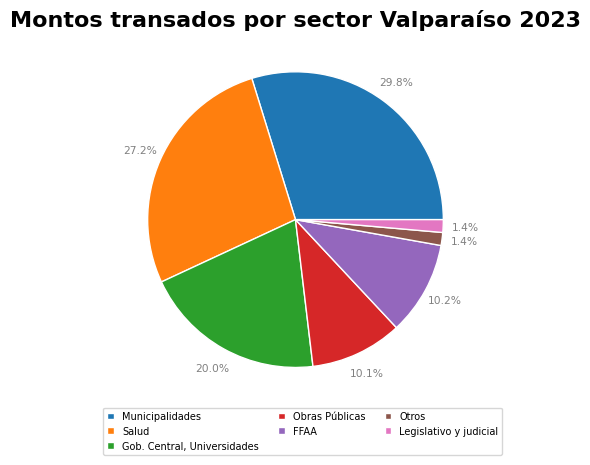

In [26]:
###################################################
###   Llenado diccionario/contexto y template   ###
###################################################

#Importar template
docu = DocxTemplate("docxtpl.docx")

#Settear diccionario nacional
contextoNac = {'ano' : str(anoReg),
               'anoM' : str(anoRegM),
               'mesI' : meses[mes_i - 1],   #llama nombre del mes para usar en reporte
               'mesF' : meses[mes_f - 1]}

#settear diccionario adicionales regionales
adicionalesReg = impAdicionalesReg()

dicGlob = {}


#Iterador de regiones/documentos
for r in listReg:
    print('')
    print(r)
    contexto = setContextoReg(r)

    rTotReg = TotReg.loc[TotReg['Region'] == r]
    contexto.update(agregarTotalesRegion(rTotReg, mndTotReg))

    #tamaño empresa
    listColTmnReg = ['Tamano']
    rTmnReg = extraerDataframe (TotRegBig, r, listColTmnReg)

    # dtoTmnReg 
    rTmnReg = fmtoDataframe(rTmnReg, colDtoTmnReg)

    #----Código auxiliar para sumar mipyme y sin dato---------------#
    #----Código auxiliar para sumar mipyme y sin dato---------------#
    #----Sumar en dataframe para usa fnc dataframeDiccionario()-----#
    print('entra a aux')
    anctxt = {}
    adf = rTmnReg
    adto = dtoTmnReg
    atot = adf['CLP'].sum() #total de referencia para porcentajes

    mpmRegTot = adf.loc[adf[''] == 'MiPyme'].iloc[0,5]
    tmnRegTot = adf.loc[adf[''] == 'Grande'].iloc[0,5] + mpmRegTot

    anctxt['totRegMipyme'] = fmtoEntero(mpmRegTot, 'CLP')
    anctxt['totRegTmnTOTAL'] = fmtoEntero(tmnRegTot, 'CLP')
    anctxt['totRegMipymePct'] = fmtoPorcien((mpmRegTot/tmnRegTot))

    print('sale a aux')
    #----Fin Cod Auxiliar----#
    #----Fin Cod Auxiliar----#

    contexto.update(anctxt)

    #modalidad de compra
    listColModReg = ['Modalidad']
    rModReg = extraerDataframe (TotRegBig, r, listColModReg)
    rModReg = fmtoDataframe(rModReg, colDtoModReg)    
    contexto.update(dataframeDiciconario(rModReg, dtoModReg, topModReg))


   
    rPrvReg = PrvReg.loc[PrvReg['Region'] == r]
    colDtoPrvReg = 'RazonSocialSucursal'
    dtoPrvReg = 'prvReg'
    rPrvReg = fmtoDataframe(rPrvReg, colDtoPrvReg)
    contexto.update(dataframeDiciconario(rPrvReg, dtoPrvReg, topPrvReg))
    
    
    rInsReg = InsReg.loc[InsReg['Region'] == r]
    contexto.update(agregarInsitucionRegion(rInsReg, topInsReg, mndInsReg))

    rRubReg = RubReg.loc[RubReg['Region'] == r]
    contexto.update(agregarMontoRubrosRegion(rRubReg, topRubReg, mndRubReg))

    rOCReg = OCReg.loc[OCReg['Region'] == r]
    contexto.update(agregarOrdenCompraRegion(rOCReg, mndOCReg))

    rSecReg = SecReg.loc[SecReg['region'] == r]
    contexto.update(agregarMontoSectorRegion(rSecReg, topSecReg, mndSecReg))
    titGrafSecReg = contexto['nomCt'] + ' ' + str(anoReg)
    contexto.update(agregarGrafMontoSectorRegion(rSecReg, mndSecReg, titGrafSecReg)) #remover grafico despues de renderizar

    rCAReg = CAReg.loc[CAReg['Region'] == r]
    contexto.update(agregarCARegion(rCAReg, mndCAReg))

    contexto.update(adicionalesReg[r])

    contexto.update(contextoNac)
    
    
    print(contexto)
    dicGlob.update({r: contexto})

    docu.render(contexto)
    #os.remove(titGrafSecReg +'.png')    #según cantidad de gráficos se podría iterar
    #2023 plantilla cifras regionales
    nomDocu = contexto['ano'] + ' cifras regionales ' + contexto['nomCt'] + ' ' + contexto['mesI'] + '-' + contexto['mesF']
    docu.save('reportes/'+nomDocu+'.docx')


In [27]:
#######################################################
# Exporta planilla con todos los contextos regionales #
#######################################################

dfGlob = pd.DataFrame(dicGlob)
dfGlob.to_excel('dfGlob.xlsx')

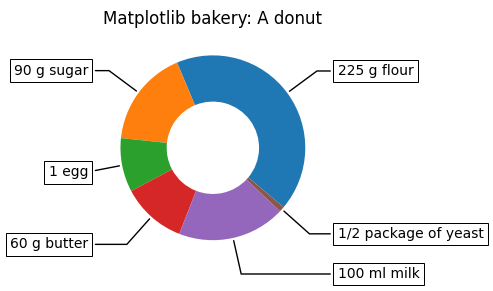

In [28]:
#####################################################
###    Referencia/Ejemplo para refinar gráfico    ###
#####################################################

#No afecta al programa
fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ["225 g flour",
          "90 g sugar",
          "1 egg",
          "60 g butter",
          "100 ml milk",
          "1/2 package of yeast"]

data = [225, 90, 50, 60, 100, 5]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Matplotlib bakery: A donut")

plt.show()
#Fin Ref---------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
###########################
#   Probar Crear Tablas   #
###########################

#Importar template
docu = DocxTemplate("tablas.docx")

#Settear diccionario nacional
contexto = {'ano' : str(anoReg),
               'anoM' : str(anoRegM)}

#settear diccionario adicionales regionales
adicionalesReg = impAdicionalesReg()

tttt =  """
        <table>
            <tr>
                <th>Institución</th>
                <th>Código orden de compra</th>
                <th>Motivo de la compra</th>
                <th>Proveedor</th>
                <th>Monto comprometido en US$</th>
            </tr>
            <tr>
                <td></td>
                <td></td>
                <td></td>
                <td></td>
                <td></td>
            </tr>
            
        </table>
        """

print('')

contexto['tablita'] = tttt

print(contexto)
docu.render(contexto)
docu.save('tablasnew.docx')


{'ano': '2023', 'anoM': '2022', 'tablita': '\n        <table>\n            <tr>\n                <th>Institución</th>\n                <th>Código orden de compra</th>\n                <th>Motivo de la compra</th>\n                <th>Proveedor</th>\n                <th>Monto comprometido en US$</th>\n            </tr>\n            <tr>\n                <td></td>\n                <td></td>\n                <td></td>\n                <td></td>\n                <td></td>\n            </tr>\n            \n        </table>\n        '}
